# **ECS 7001 - NN & NNLP**

## **Lab 2: Skip-gram Model for Word2Vec**

<br>

**1st February**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture.

The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: (1) using a hierarchical softmax function and/or (2) by negative sampling. In this lab, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [1]:
import nltk
import tensorflow as tf
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer 
import re
from collections import Counter
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FiercePC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\FiercePC\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


**Sanity check:**

This training corpus contains 16498 sentences. The following print statement should return 16498.

In [2]:
print(len(austen))

16498


In [3]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

In [4]:
len(austen[0])

9

### **2. Preprocessing the Training Corpus**

Remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. You might also consider removing sentences with fewer than 3 words or at least empty sentences.



In [5]:

def preprocess_corpus(corpus):
    '''
    Write code for preprocessing corpus here
    '''
    processedCorpus = []
    for line in corpus:
        
        untoken = TreebankWordDetokenizer().detokenize(line) # To detokenize the tokens for easier preprocessing
        Text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", untoken) # Separating words and special charaters from words that comes after the word
        Text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", Text) # Separating words and special charaters from words that comes before the word
        Text = re.sub(r"(//d)(\w)", r"\1 \2", Text) # Removing digits
        tokenizer = RegexpTokenizer(r'\w+')         # Initialize tokenizer
        tokens = tokenizer.tokenize(Text)           # Tokenize the words
        tokens = [t.lower() for t in tokens]        # Lowercased the tokens
        stop = set(stopwords.words('english'))      # Stop contains all the stopwords in the english vocab
        tokens = [t for t in tokens if t not in stop] # Removes all stopwords
        if len(tokens)>2:                           # Removes sentences that has less that two words. Only 3 and above are kept.
            processedCorpus.append(tokens)          # Append tokens to local list

    #print(len(processedCorpus))
    return processedCorpus                          # Returns processed tokens


normalized_corpus = preprocess_corpus(austen)
print('The new length of the preprocessed output', len(normalized_corpus))

The new length of the preprocessed output 13938


In [6]:
processedtext = preprocess_corpus(austen)
processedtext

[['sense', 'sensibility', 'jane', 'austen', '1811'],
 ['family', 'dashwood', 'long', 'settled', 'sussex'],
 ['estate',
  'large',
  'residence',
  'norland',
  'park',
  'centre',
  'property',
  'many',
  'generations',
  'lived',
  'respectable',
  'manner',
  'engage',
  'general',
  'good',
  'opinion',
  'surrounding',
  'acquaintance'],
 ['late',
  'owner',
  'estate',
  'single',
  'man',
  'lived',
  'advanced',
  'age',
  'many',
  'years',
  'life',
  'constant',
  'companion',
  'housekeeper',
  'sister'],
 ['death',
  'happened',
  'ten',
  'years',
  'produced',
  'great',
  'alteration',
  'home',
  'supply',
  'loss',
  'invited',
  'received',
  'house',
  'family',
  'nephew',
  'mr',
  'henry',
  'dashwood',
  'legal',
  'inheritor',
  'norland',
  'estate',
  'person',
  'intended',
  'bequeath'],
 ['society',
  'nephew',
  'niece',
  'children',
  'old',
  'gentleman',
  'days',
  'comfortably',
  'spent'],
 ['constant',
  'attention',
  'mr',
  'mrs',
  'henry',
  

In [7]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)

print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]

2 [['sense', 'sensibility', 'jane', 'austen', '1811'], ['mrs', 'dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, you will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

In [8]:
word2idx = {}   # A dictionary of words and their uniquely assigned integers
idx2word = {}
def prepareData(normalized_corpus):
    i = len(word2idx)             # Word count
    for word in normalized_corpus:
        for w in word:
            if w not in word2idx:   # Checks if word is in the dictionary
                word2idx[w]= i # Adds word and its uniquely assigned integer in the word2idx dictionary
                idx2word[i]= w # Adds uniquely assigned integer and its word in the idx2word dictionary
                i =len(word2idx) +1 # Adds count to i
    return word2idx


sents_as_ids = []
def prepareSentsAsId(normalized_corpus):
    
    for word in normalized_corpus:
        inner = []
        for w in word:
            inner.append(word2idx[w])  # Finds the index to the word and appends it to inner list
        sents_as_ids.append(inner)     # Once every token in the list is transformed, its appended to sents_as_ids list
    return sents_as_ids



In [9]:
prepareData(processedtext)

{'sense': 0,
 'sensibility': 2,
 'jane': 3,
 'austen': 4,
 '1811': 5,
 'family': 6,
 'dashwood': 7,
 'long': 8,
 'settled': 9,
 'sussex': 10,
 'estate': 11,
 'large': 12,
 'residence': 13,
 'norland': 14,
 'park': 15,
 'centre': 16,
 'property': 17,
 'many': 18,
 'generations': 19,
 'lived': 20,
 'respectable': 21,
 'manner': 22,
 'engage': 23,
 'general': 24,
 'good': 25,
 'opinion': 26,
 'surrounding': 27,
 'acquaintance': 28,
 'late': 29,
 'owner': 30,
 'single': 31,
 'man': 32,
 'advanced': 33,
 'age': 34,
 'years': 35,
 'life': 36,
 'constant': 37,
 'companion': 38,
 'housekeeper': 39,
 'sister': 40,
 'death': 41,
 'happened': 42,
 'ten': 43,
 'produced': 44,
 'great': 45,
 'alteration': 46,
 'home': 47,
 'supply': 48,
 'loss': 49,
 'invited': 50,
 'received': 51,
 'house': 52,
 'nephew': 53,
 'mr': 54,
 'henry': 55,
 'legal': 56,
 'inheritor': 57,
 'person': 58,
 'intended': 59,
 'bequeath': 60,
 'society': 61,
 'niece': 62,
 'children': 63,
 'old': 64,
 'gentleman': 65,
 'days':

In [10]:
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))



Sample word2idx:  [('sense', 0), ('sensibility', 2), ('jane', 3), ('austen', 4), ('1811', 5), ('family', 6), ('dashwood', 7), ('long', 8), ('settled', 9), ('sussex', 10)]

Sample idx2word: [(0, 'sense'), (2, 'sensibility'), (3, 'jane'), (4, 'austen'), (5, '1811'), (6, 'family'), (7, 'dashwood'), (8, 'long'), (9, 'settled'), (10, 'sussex')]

Sample sents_as_id: [[0, 2, 3, 4, 5], [70, 7, 196, 594, 35, 595, 287, 596]]


After you have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [11]:
VOCAB_SIZE = len(word2idx)
EMBED_SIZE = 100 # We are creating 100D embeddings.

In [12]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10283


### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

In [13]:
sents_as_ids

[[0, 2, 3, 4, 5], [70, 7, 196, 594, 35, 595, 287, 596]]

In [14]:
from keras.preprocessing.sequence import skipgrams
# your code for generating training examples goes here

skip_grams = [skipgrams(wid, vocabulary_size=VOCAB_SIZE, window_size=4) for wid in sents_as_ids]

In [15]:
#skip_grams
skip_grams[0][0]
#skip_grams[0][1]

[[2, 3],
 [5, 10019],
 [4, 2],
 [4, 4689],
 [5, 3],
 [5, 5216],
 [3, 2],
 [3, 9372],
 [4, 2873],
 [4, 3],
 [2, 4],
 [4, 6962],
 [2, 5575],
 [5, 4],
 [3, 4],
 [4, 5],
 [2, 9726],
 [2, 5],
 [5, 2],
 [3, 5],
 [3, 2030],
 [2, 3228],
 [5, 7507],
 [3, 3699]]

In [16]:
#skip_grams = [skipgrams(preprocessed_sample, vocabulary_size=VOCAB_SIZE, window_size=10) for wid in sents_as_ids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(sensibility (2), jane (3)) -> 1
(1811 (5), laundress (10019)) -> 0
(austen (4), sensibility (2)) -> 1
(austen (4), affectedly (4689)) -> 0
(1811 (5), jane (3)) -> 1
(1811 (5), easter (5216)) -> 0
(jane (3), sensibility (2)) -> 1
(jane (3), spelt (9372)) -> 0
(austen (4), fortitude (2873)) -> 0
(austen (4), jane (3)) -> 1


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model.

In [17]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model


The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input using the following lines of code:**

In [18]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

####**B. Write similar code for the ‘context_word’ input.**

In [19]:
# your code for the context_word goes here
context_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(context_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
context_input = Reshape((EMBED_SIZE, ))(context_embedding)

####**C. Merge the inputs.**




In [20]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

####**D. The Output Layer**



In [21]:
# your code for the output layer goes here
outputLayer = (Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))(merged_inputs)

####**E. Initialize the model:**

In [22]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[outputLayer])  

####**F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [23]:
# your code here
model.compile(loss="mean_squared_error", optimizer="rmsprop")

**Sanity check:**

Visualize the model and the model summary by running the following lines of code. 
view the model summary

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1028300     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1028300     input_2[0][0]                    
______________________________________________________________________________________________

In [73]:
# Default result for comparison
# Model: "model"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_2 (InputLayer)            [(None, 1)]          0                                            
# __________________________________________________________________________________________________
# input_4 (InputLayer)            [(None, 1)]          0                                            
# __________________________________________________________________________________________________
# target_embed_layer (Embedding)  (None, 1, 100)       1018000     input_2[0][0]                    
# __________________________________________________________________________________________________
# context_embed_layer (Embedding) (None, 1, 100)       1018000     input_4[0][0]                    
# __________________________________________________________________________________________________
# reshape (Reshape)               (None, 100)          0           target_embed_layer[0][0]         
# __________________________________________________________________________________________________
# reshape_1 (Reshape)             (None, 100)          0           context_embed_layer[0][0]        
# __________________________________________________________________________________________________
# dot (Dot)                       (None, 1)            0           reshape[0][0]                    
#                                                                  reshape_1[0][0]                  
# __________________________________________________________________________________________________
# dense_2 (Dense)                 (None, 1)            2           dot[0][0]                        
# ==================================================================================================
# Total params: 2,036,002
# Trainable params: 2,036,002
# Non-trainable params: 0

####**G. Plot the model using ```vis utils```.**

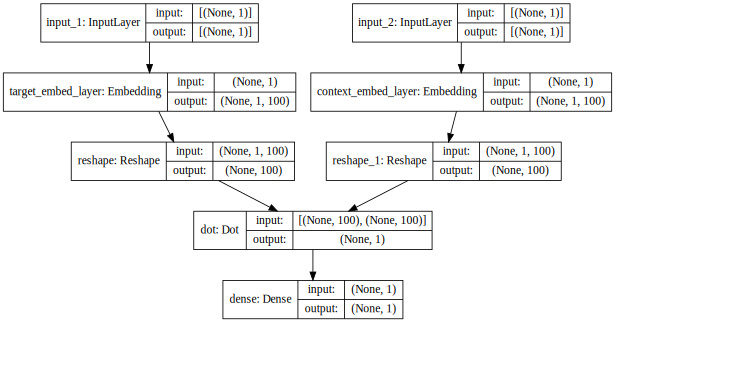

In [26]:
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


###**6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [51]:
import numpy as np

NUM_EPOCHS = 2000  # upped the number of epochs to 2000. 5 epochs only took a few seconds to train.

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')



Processed 0 sentences
Processed all 1 sentences
Epoch: 1 Loss: 4.3126913151780855e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 2 Loss: 4.250589991094955e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 3 Loss: 4.192207803122017e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 4 Loss: 4.1328472866197785e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 5 Loss: 4.075829673766407e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 6 Loss: 4.018957722173866e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 7 Loss: 3.963533168338529e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 8 Loss: 3.911079238250181e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 9 Loss: 3.858826258529291e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 10 Loss: 3.807719806125931e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 11 Loss: 3.757452238239978e-09 

Processed 0 sentences
Processed all 1 s

Processed all 1 sentences
Epoch: 100 Loss: 1.6066444841200678e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 101 Loss: 1.5955399224054645e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 102 Loss: 1.5855334545289423e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 103 Loss: 1.5732604108364967e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 104 Loss: 1.562543788802273e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 105 Loss: 1.552491107892351e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 106 Loss: 1.5425762889265116e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 107 Loss: 1.5316639900841977e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 108 Loss: 1.5215000370716325e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 109 Loss: 1.5116537188664125e-09 

Processed 0 sentences
Processed all 1 sentences
Epoch: 110 Loss: 1.5018029875246697e-09 

Processed 0 sentences
Processed al

Processed all 1 sentences
Epoch: 199 Loss: 9.346211582439423e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 200 Loss: 9.305904102863138e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 201 Loss: 9.269067458017588e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 202 Loss: 9.225532837664474e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 203 Loss: 9.185114058229971e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 204 Loss: 9.146267909709849e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 205 Loss: 9.103171549895706e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 206 Loss: 9.065188322221474e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 207 Loss: 9.029369751889504e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 208 Loss: 8.99115198960132e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 209 Loss: 8.954678942796335e-10 

Processed 0 sentences
Processed all 1 senten

Processed all 1 sentences
Epoch: 292 Loss: 6.621199699630154e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 293 Loss: 6.603207008959444e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 294 Loss: 6.578022432313091e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 295 Loss: 6.561835380614056e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 296 Loss: 6.535525315376489e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 297 Loss: 6.515924050320976e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 298 Loss: 6.496221477414466e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 299 Loss: 6.4767091689788e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 300 Loss: 6.457506751544884e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 301 Loss: 6.435262461801372e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 302 Loss: 6.415942083171089e-10 

Processed 0 sentences
Processed all 1 sentenc

Processed all 1 sentences
Epoch: 394 Loss: 4.983425894167226e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 395 Loss: 4.976163092695884e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 396 Loss: 4.965823724445428e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 397 Loss: 4.95197369221323e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 398 Loss: 4.942246473182976e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 399 Loss: 4.923715463123202e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 400 Loss: 4.91877275021757e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 401 Loss: 4.9070610075308e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 402 Loss: 4.892782012877461e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 403 Loss: 4.88152671063169e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 404 Loss: 4.870561176595345e-10 

Processed 0 sentences
Processed all 1 sentences


Processed all 1 sentences
Epoch: 492 Loss: 4.019860555537491e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 493 Loss: 4.015495366771482e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 494 Loss: 4.002996267793435e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 495 Loss: 4.000576050988691e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 496 Loss: 3.9909726218256836e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 497 Loss: 3.98145773294889e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 498 Loss: 3.974572615472738e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 499 Loss: 3.9665840750879866e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 500 Loss: 3.957019503730841e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 501 Loss: 3.948550167387488e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 502 Loss: 3.9419199154844264e-10 

Processed 0 sentences
Processed all 1 sen

Processed all 1 sentences
Epoch: 592 Loss: 3.3526176279607967e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 593 Loss: 3.345498808537961e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 594 Loss: 3.344729701537652e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 595 Loss: 3.3384931624746983e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 596 Loss: 3.331223699665209e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 597 Loss: 3.323600075710864e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 598 Loss: 3.3183265163438946e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 599 Loss: 3.3119649384127925e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 600 Loss: 3.3127272452970757e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 601 Loss: 3.3061326593086804e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 602 Loss: 3.301486584117441e-10 

Processed 0 sentences
Processed all 1

Processed all 1 sentences
Epoch: 686 Loss: 2.898624396063809e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 687 Loss: 2.8926417511287994e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 688 Loss: 2.8900920545638087e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 689 Loss: 2.8834303694713626e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 690 Loss: 2.8823562286950377e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 691 Loss: 2.87657127284735e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 692 Loss: 2.8730694906498044e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 693 Loss: 2.869568402341649e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 694 Loss: 2.8673687729741104e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 695 Loss: 2.857737518846548e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 696 Loss: 2.8590770029257584e-10 

Processed 0 sentences
Processed all 1

Processed all 1 sentences
Epoch: 781 Loss: 2.5457107949433677e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 782 Loss: 2.5429561928413946e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 783 Loss: 2.5392812852409463e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 784 Loss: 2.5374182616166863e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 785 Loss: 2.532774198704679e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 786 Loss: 2.5319488866637485e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 787 Loss: 2.527742806734956e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 788 Loss: 2.5267789943717034e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 789 Loss: 2.5201907227767606e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 790 Loss: 2.5210284554377793e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 791 Loss: 2.515699870642152e-10 

Processed 0 sentences
Processed all

Processed all 1 sentences
Epoch: 876 Loss: 2.270293883444019e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 877 Loss: 2.269344087646452e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 878 Loss: 2.2674429001057206e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 879 Loss: 2.26297168504086e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 880 Loss: 2.2630257390243713e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 881 Loss: 2.2589017462104621e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 882 Loss: 2.2567521462679707e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 883 Loss: 2.253023392850828e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 884 Loss: 2.2511012498505067e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 885 Loss: 2.2464835547353346e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 886 Loss: 2.2445097863643682e-10 

Processed 0 sentences
Processed all 1

Processed all 1 sentences
Epoch: 969 Loss: 2.0549073206921342e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 970 Loss: 2.049089196931586e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 971 Loss: 2.0487284091430524e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 972 Loss: 2.0478900172871128e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 973 Loss: 2.0433993039303822e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 974 Loss: 2.0408323642140402e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 975 Loss: 2.0405234099629688e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 976 Loss: 2.0391337576808333e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 977 Loss: 2.03313619412393e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 978 Loss: 2.0313402002147818e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 979 Loss: 2.0331025404884961e-10 

Processed 0 sentences
Processed all

Processed all 1 sentences
Epoch: 1064 Loss: 1.8694398459806472e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1065 Loss: 1.8640890567245272e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1066 Loss: 1.8652055247536659e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1067 Loss: 1.861256253288257e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1068 Loss: 1.8591653563881927e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1069 Loss: 1.8585097003032125e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1070 Loss: 1.8591170616866215e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1071 Loss: 1.8548589400535498e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1072 Loss: 1.8561477702072615e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1073 Loss: 1.8553181560521104e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1074 Loss: 1.850966359351336e-10 

Processed 0 sentences
P

Processed all 1 sentences
Epoch: 1161 Loss: 1.7102599544904784e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1162 Loss: 1.7101670080066356e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1163 Loss: 1.7077261826869972e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1164 Loss: 1.7083727835154328e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1165 Loss: 1.706345099938833e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1166 Loss: 1.7020413203838736e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1167 Loss: 1.7020003809098405e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1168 Loss: 1.7003536426085653e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1169 Loss: 1.7003373709023606e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1170 Loss: 1.6986141312957947e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1171 Loss: 1.695167513304785e-10 

Processed 0 sentences
P

Epoch: 1255 Loss: 1.5814438647510087e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1256 Loss: 1.582565641033984e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1257 Loss: 1.5806185180156085e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1258 Loss: 1.5785750831498468e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1259 Loss: 1.5779741749377685e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1260 Loss: 1.5766584912646486e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1261 Loss: 1.574686110672463e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1262 Loss: 1.5726374716362734e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1263 Loss: 1.572205386712877e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1264 Loss: 1.5686896573385845e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1265 Loss: 1.5689992013956378e-10 

Processed 0 sentences
Processed all 1 sentences
Ep

Processed all 1 sentences
Epoch: 1351 Loss: 1.468046205432838e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1352 Loss: 1.467154696344064e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1353 Loss: 1.467494736839825e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1354 Loss: 1.4638055351179347e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1355 Loss: 1.4637933573591333e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1356 Loss: 1.463351315122985e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1357 Loss: 1.4622109079098777e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1358 Loss: 1.462600179857887e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1359 Loss: 1.461381987644117e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1360 Loss: 1.4590814667592156e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1361 Loss: 1.457360586376577e-10 

Processed 0 sentences
Proces

Processed all 1 sentences
Epoch: 1447 Loss: 1.370397718913896e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1448 Loss: 1.3692415257171575e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1449 Loss: 1.370297417202515e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1450 Loss: 1.3665657841444023e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1451 Loss: 1.3669174472874523e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1452 Loss: 1.3669323659093457e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1453 Loss: 1.3644366539389274e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1454 Loss: 1.3646729232763555e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1455 Loss: 1.3654969863163835e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1456 Loss: 1.3621498026750167e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1457 Loss: 1.361416847311947e-10 

Processed 0 sentences
Pr

Processed all 1 sentences
Epoch: 1546 Loss: 1.27906071151207e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1547 Loss: 1.2825073295030798e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1548 Loss: 1.2806067664627996e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1549 Loss: 1.278056549480766e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1550 Loss: 1.2782191624594041e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1551 Loss: 1.2771746160655795e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1552 Loss: 1.2765376602996703e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1553 Loss: 1.2761487006018868e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1554 Loss: 1.2737259857953376e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1555 Loss: 1.2722505687845498e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1556 Loss: 1.2740272031797062e-10 

Processed 0 sentences
Pr

Processed all 1 sentences
Epoch: 1644 Loss: 1.2052828179953679e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1645 Loss: 1.2034737442712107e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1646 Loss: 1.203499869206759e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1647 Loss: 1.2023650478032444e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1648 Loss: 1.2006070790326895e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1649 Loss: 1.202532240451859e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1650 Loss: 1.198809940206047e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1651 Loss: 1.2004381169661293e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1652 Loss: 1.1995349852300663e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1653 Loss: 1.1964086318871914e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1654 Loss: 1.1962830379075307e-10 

Processed 0 sentences
Pr

Processed all 1 sentences
Epoch: 1740 Loss: 1.1358182103182735e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1741 Loss: 1.1366542429502857e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1742 Loss: 1.1367850064059049e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1743 Loss: 1.1361916962826513e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1744 Loss: 1.1344700873161528e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1745 Loss: 1.1348989803483533e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1746 Loss: 1.1355095683174277e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1747 Loss: 1.1336538999207058e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1748 Loss: 1.1316506412506477e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1749 Loss: 1.1311599920627025e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1750 Loss: 1.1301827876342152e-10 

Processed 0 sentences

Processed all 1 sentences
Epoch: 1840 Loss: 1.0748792481085623e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1841 Loss: 1.0736299002611638e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1842 Loss: 1.0751659632046717e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1843 Loss: 1.071859285356469e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1844 Loss: 1.0729020449851134e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1845 Loss: 1.0700585556522313e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1846 Loss: 1.0725405633071894e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1847 Loss: 1.0694519055054474e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1848 Loss: 1.0701533756374282e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1849 Loss: 1.0690625294740297e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1850 Loss: 1.0687890676652767e-10 

Processed 0 sentences


Processed all 1 sentences
Epoch: 1934 Loss: 1.0215621230880156e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1935 Loss: 1.0209207784717123e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1936 Loss: 1.0221570291568671e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1937 Loss: 1.0199268686561513e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1938 Loss: 1.0197802845224313e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1939 Loss: 1.0187122499727419e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1940 Loss: 1.0195814852120844e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1941 Loss: 1.0175314237026445e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1942 Loss: 1.0178458943743696e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1943 Loss: 1.0175080396301883e-10 

Processed 0 sentences
Processed all 1 sentences
Epoch: 1944 Loss: 1.0163262766094139e-10 

Processed 0 sentences

###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [52]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10283, 100)


Print out a few words and their embeddings using the next block of code. Your output may not be exactly as above but the command should print 10 words and their respective vectors.

In [53]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                   0         1         2         3         4         5   \
sense       -0.011722 -0.003500 -0.015867  0.013256 -0.023580  0.012802   
sensibility  0.021610  0.009224 -0.018143  0.000592  0.004712 -0.004603   
jane        -0.378793 -0.407600 -0.371347  0.378397  0.028467 -0.401978   
austen      -0.399012 -0.413519 -0.409555  0.405166  0.412595  0.013353   
1811        -0.378490 -0.403483 -0.387947  0.386520  0.404204 -0.388492   
family      -0.402996 -0.396447 -0.410824  0.392458  0.382214 -0.365615   
dashwood    -0.002968  0.022947 -0.003056 -0.019743 -0.020792  0.016837   
long        -0.411424  0.406284  0.397844  0.407512 -0.091003 -0.410612   
settled     -0.020786 -0.023026  0.023551 -0.011938 -0.020531 -0.013634   
sussex      -0.010563  0.014681  0.017876 -0.015181 -0.019278  0.008495   

                   6         7         8         9   ...        90        91  \
sense        0.023217 -0.021391  0.011935  0.018201  ... -0.019024  0.002741   
sensibility  0

###**8.  Measuring Similarity Between Word Pairs**



In [60]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10283, 10283)


###**9. Exploring and Visualizing your Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']




In [79]:
from sklearn.metrics.pairwise import euclidean_distances

#search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']
search_terms = ['family', 'love', 'equality', 'wisdom', 'justice', 'humour', 'rejection']

# write code to get the 5 words most similar to the words in search_terms
distance_matrix = euclidean_distances(similarity_matrix)
print(distance_matrix.shape)

similar_words = {search_term: [idx2word[idx] for idx in distance_matrix[word2idx[search_term]-1].argsort()[1:6]+1] 
                   for search_term in search_terms}

similar_words

(10283, 10283)


{'family': ['1811', 'austen', 'jane', 'notch', 'adelaide'],
 'love': ['joy', 'saw', 'defended', 'likely', 'nominal'],
 'equality': ['villages', 'permanent', 'teasing', 'lofty', 'baldwin'],
 'wisdom': ['insured', 'streamed', 'subsided', 'irremediable', 'vacate'],
 'justice': ['squire', 'advancement', 'foresee', 'drew', 'clearer'],
 'humour': ['advantageous',
  'personage',
  'abbots',
  'restoratives',
  'unintelligible'],
 'rejection': ['liberality', 'sleek', 'uses', 'impression', 'seating']}

**B. Plot the words in the dictionary above using t-SN**E https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














Total words: 42 	Word Embedding shapes: (42, 100)


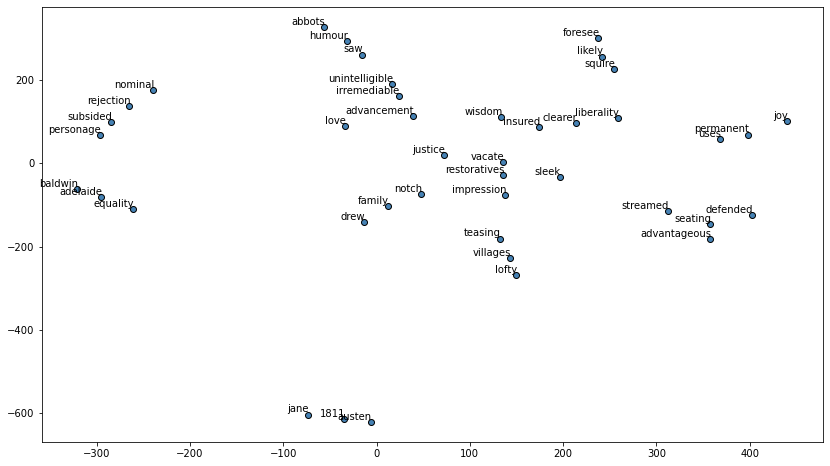

In [80]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2idx[w] for w in words]
word_vectors = np.array([word_embeddings[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')

**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

